In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import pandas as pd
import json
import importlib
sys.path.insert(0, '../utils')
import data_utils, run_utils

/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### WNET

In [2]:
'''
Quickly summarize trained models
'''

models = json.load(open('../../WNet_runs/exp_dicts.json'))
mods = pd.DataFrame(models).drop(columns=['img_dir', 'seg_dir', 'img_size', 'num_sup', 'freeze_dec', 'batch_size'])
mods

#  { "WNet_name": "WNet37nm",
#     "n_classes": 3,
#     "channels": ["X", "timeseries_80_5"],
#     "weights": [1],
#     "img_dir": "../Data/UNetData_MURaM/norm_images/",
#     "seg_dir": "../Data/UNetData_MURaM/seg_images/",
#     "img_size": 128,
#     "randomSharp": false,
#     "smooth_loss": true,
#     "blob_loss": false,
#     "padding_mode": "replicate",
#     "load_model": false,
#     "num_epochs": 3, 
#     "num_sup": 0, 
#     "freeze_dec": false,
#     "batch_size": 16,
#     "learning_rate": 0.0003}


,WNet_name,n_classes,channels,weights,randomSharp,smooth_loss,blob_loss,padding_mode,load_model,num_epochs,learning_rate
0,WNet29nm,3,[X],"[1, 4]",False,True,False,zeroes,False,3,0.0003
1,WNet31nm,3,[X],"[1, 4]",False,True,False,reflect,False,3,0.0003
2,WNet34nm,3,"[X, median_residual]",[1],False,True,False,reflect,False,3,0.0003
3,WNet35nm,3,"[X, median_residual]","[1, 4]",False,True,False,reflect,False,3,0.0003
4,WNet36nm,3,[X],[1],False,True,False,replicate,False,3,0.0003


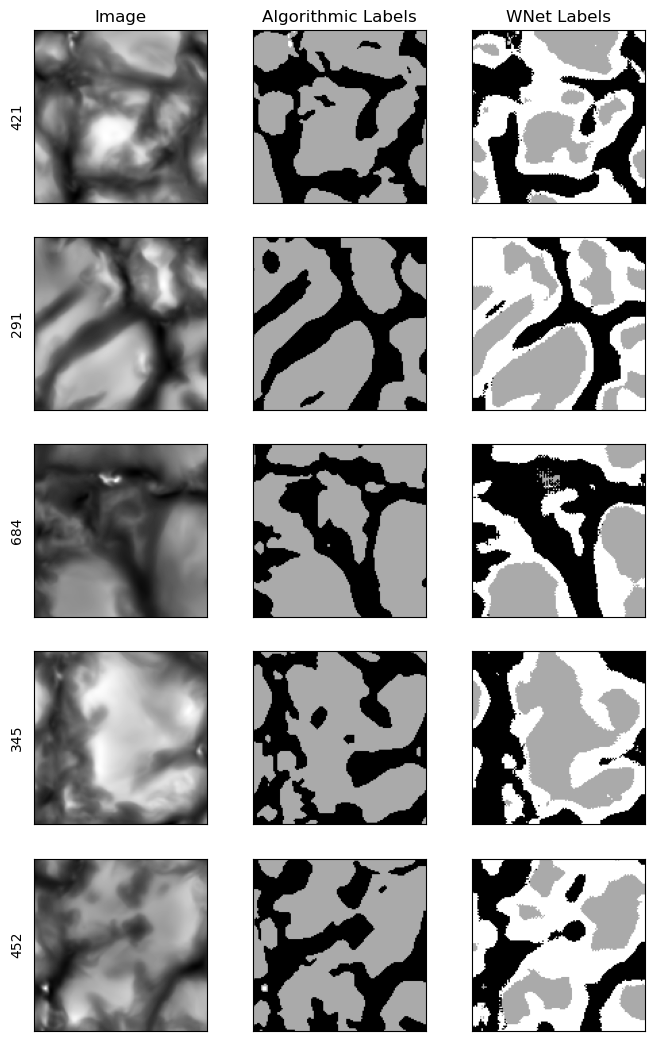

In [9]:
'''
Display a random sample of images for one model
'''

WNet_num = '35nm'
output_dir = f'../../WNet_runs/exp{WNet_num}/WNet{WNet_num}_outputs'
fig, axs = plt.subplots(5, 3, figsize=(8, 13))
axs[0,0].set_title('Image')
axs[0,1].set_title('Algorithmic Labels')
axs[0,2].set_title('WNet Labels')
target_pos = 2 if 'timeseries' in mods[mods['WNet_name']==f"WNet{WNet_num}"] else 0
for i in range(5): 
    idx = np.random.randint(0, len([file for file in os.listdir(output_dir) if file.startswith('x')]))
    im = np.load(f'{output_dir}/x_{idx}.npy')[target_pos]
    true = np.load(f'{output_dir}/true_{idx}.npy')
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    axs[i,0].imshow(im, cmap='gist_gray'); axs[i,0].set_ylabel(idx)
    axs[i,1].imshow(true, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,2].imshow(preds, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,0].xaxis.set_tick_params(labelbottom=False); axs[i,0].yaxis.set_tick_params(labelleft=False); axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,1].xaxis.set_tick_params(labelbottom=False); axs[i,1].yaxis.set_tick_params(labelleft=False); axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,2].xaxis.set_tick_params(labelbottom=False); axs[i,2].yaxis.set_tick_params(labelleft=False); axs[i,2].set_xticks([]); axs[i,2].set_yticks([])
plt.suptitle(f'WNet {WNet_num}')
plt.savefig(f'{output_dir}/WNet{WNet_num}_val_examples')

FileNotFoundError: [Errno 2] No such file or directory: '../../WNet_runs/exp36nm/WNet36nm_outputs/x_131.npy'

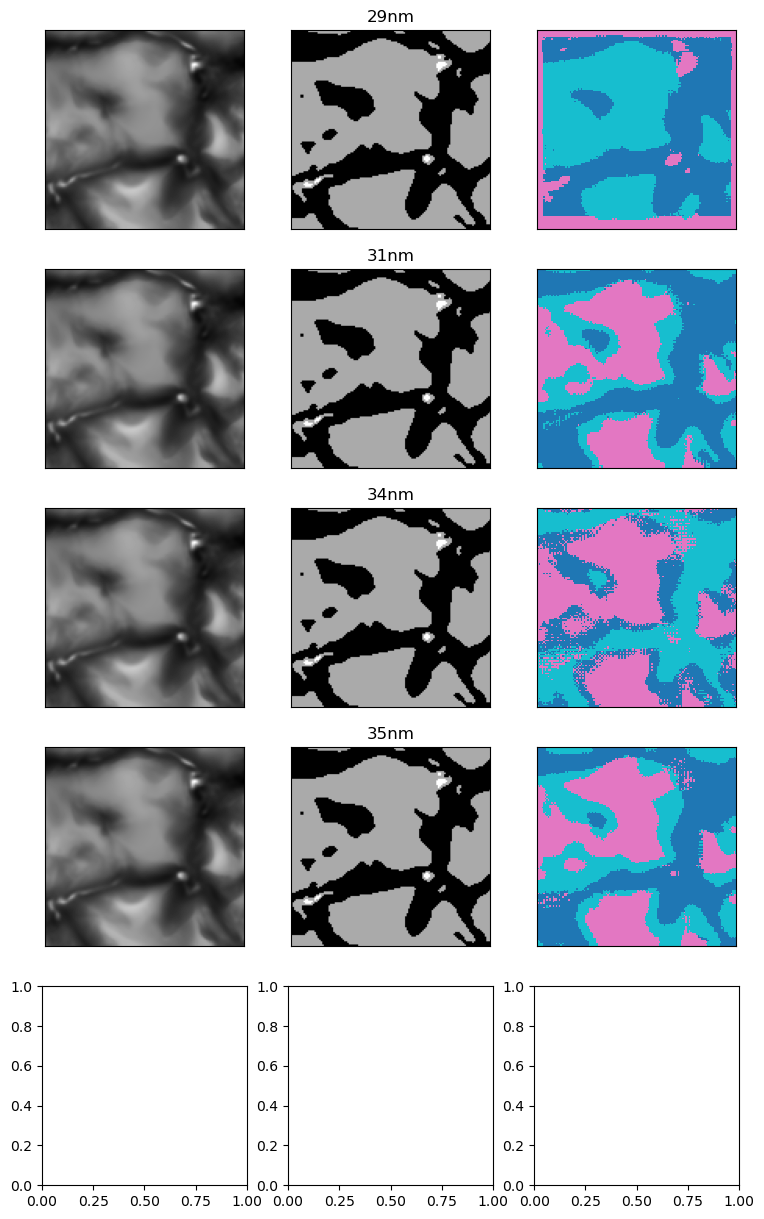

In [2]:
'''
Compare models
'''

idx = 131 # 161 # np.random.randint(0, 108)  # 131 # 131 is good image for full DKIST seg v1  ("true" seg here is still version; does not matter for training unsup, but perhaps for comparing validations)
models = ['29nm','31nm','34nm','35nm','36nm'] #list(mods['WNet_name']) # models on properly normalized data!
fig, axs = plt.subplots(len(models), 3, figsize=(9, 3*len(models)))
for i in range(len(models)):
    output_dir = f'../../WNet_runs/exp{models[i]}/WNet{models[i]}_outputs'
    target_pos = 2 if models[i]=='WNet15m' else 0
    im = np.load(f'{output_dir}/x_{idx}.npy')[target_pos] # index to get image
    true = np.load(f'{output_dir}/true_{idx}.npy')
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    if int(preds[40, 60]) == 0: # try to mostly have black be zero
        preds_copy = np.copy(preds)
        preds[preds_copy == 0.0] = 1
        preds[preds_copy == 1.0] = 0 
    axs[i,1].set_title(f'{models[i]}')
    axs[i,0].imshow(im, cmap='gist_gray')
    axs[i,1].imshow(true, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,2].imshow(preds, vmin=0, vmax=1.5, interpolation='none', cmap='tab10') #cmap='gist_gray')#cmap='tab10')
    axs[i,0].xaxis.set_tick_params(labelbottom=False); axs[i,0].yaxis.set_tick_params(labelleft=False); axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,1].xaxis.set_tick_params(labelbottom=False); axs[i,1].yaxis.set_tick_params(labelleft=False); axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,2].xaxis.set_tick_params(labelbottom=False); axs[i,2].yaxis.set_tick_params(labelleft=False); axs[i,2].set_xticks([]); axs[i,2].set_yticks([])
plt.savefig('ExamplePredictions_OneImage.png')

In [ ]:
model_dict = {
    'WNet1':'binary, 1 channel, no smooth loss',
    'WNet1m':'binary, 1 channel, no smooth loss', # Using MuRAM (so v2 seg, although thats not relevant since unsup)
    'WNet2':'4 classes, 1 channel, no smooth loss', 
    'WNet2m': 'binary, 1 channel, smooth loss',
    'WNet3':'binary, 1 channel, smooth loss (but bad weighting)',
    'WNet4m':'binary, 1 channel, smooth loss', 
    'WNet5':'3 classes, 2 channels (X, X**3), smooth loss', # trained on d, tested on m
    'WNet6':'3 classes, 4 channels (X, X**3, grad_x, grad_y), smooth loss', # trained on d, tested on m
    'WNet7':'3 classes, 4 channels (X, X**4, grad_x, grad_y), smooth loss', 
    'WNet8':'binary, 2 channels (X, X*2), smooth loss', 
    'WNet8m': 'binary, 2 channels (X, X**2), smooth loss',
    'WNet9':'', 
    'WNet10':'4 classes, 4 channels (X, X**3, grad_x, grad_y), smooth loss',
    'WNet11':'4 classes, 1 channel, smooth loss',
    'WNet12':'3 classes, 1 channel, smooth loss', # trained on d, tested on m
    'FreezeNet1': '1 epoch sup, 2 epoch unsup, 3 classes, 1 channels, smooth loss',
    'FreezeNet2': '1 epoch sup, 2 epoch unsup, 3 classes, 2 channels (X, X*2), smooth loss',
    'FreezeNet3': '2 epoch sup, NO unsup, 3 classes, 2 channels (X, X*2), smooth loss',
    'FreezeNet4': '1 epoch sup W/O decoder, 2 epoch unsup, 3 classes, 2 channels (X, X*2), smooth loss',
    'WNet13': '4 classes, 3 channels (X, X**3, smoothed), smooth loss',
    'WNet14m': '3 classes, 3 channels (X, X**2, binary_residual), smooth loss',
    'WNet15m': '3 classes, timeseries (+/-20 w/ 5 imgs), smooth loss',
    'WNet16m': '3 classes, timeseries (+/-40 w/ 5 imgs), smooth loss',
    'WNet17m': '3 classes, timeseries (+/-40 w/ 9 imgs), smooth loss', # didn't actually run?
    'WNet19m': '3 classes, 2 channels (X, mag)',
    'WNet20m': '3 classes, 2 channel (X, mag**2)',
    'WNet21m': '3 classes, 1 channel (mag**2 NO X!)',
    'WNet22m': '3 classes, 2 channels (X, mag**2), 2x MSE for mag**2, smooth loss', 
    'WNet23m': '3 classes, 2 channels (X, mag**2), 2x MSE for mag**2, more smooth loss', # why do I only have 1 epoch of this?
    'WNet24d': '3 classes, timeseries (+/-20, and DKIST28 so dt=6 w/ 5 imgs), smooth loss',
    'WNet25m': '3 classes, 2 channels (X, mag**2), 2x MSE for mag**2, more smooth loss, blob loss',
    'WNet26m': '3 classes, 2 channels (X, mag**2), 2x MSE for mag**2, more smooth loss, less blob loss', # but really probabaly just need another loss term...
    'WNet27': '3 classes, 2 channels (X, X-med30), more smooth loss, less blob loss',
    'WNet28': '3 classes, 2 channels (X, X-med30), more smooth loss, no blob loss',
    'WNet29nm':'3 classes, 1 channel, smooth loss',  # n = PROPERLY NORMALIZED
    'UNet30nm':'3 classes, 1 channel, smooth loss',  # n = PROPERLY NORMALIZED - THIS IS A UNET
    'WNet31nm':'3 classes, 1 channel, smooth loss, reflect', # n = PROPERLY NORMALIZED, reflect = REFLECT PADDING_MODE
    'WNet32nm':'3 classes, 2 channels (X, X-med30), smooth loss, reflect', # n = PROPERLY NORMALIZED
    } 

#### Traditional 

In [ ]:
# Get data
path = "../Data/All_DKIST/FirstLight.fits"
data = fits.open(path)[0].data
labels = np.squeeze(fits.open("../Data/All_DKIST/SEGv2_FirstLight")[0].data) # just to check against

# Cut and flatten
data = data[100:300, 100:300]
labels = labels[100:300, 100:300]
dataflat = data.reshape(-1)

# Plot for comparison
plt.figure(figsize=(3, 3))
plt.imshow(data, cmap='gray', origin='lower')
plt.title('Initial data (HE)')
plt.figure()

# Create features and put into df (skip kernel feature for now - contain inf and probably not super useful anyway)
df = pd.DataFrame()
df['OG_value'] = dataflat
df = data_utils.add_gradient_feats(df, data) # Add value of (non-HE) gradient as feature
df = data_utils.add_sharpening_feats(df, dataflat) # Add value of sharpening filters as features RIGHT NOW JUST SQUARED

In [ ]:
'''
KMeans (best)
    Clusters by separating into n groups of equal variance, minimizing within-cluster sum-of-squares
    Overall, this seems to overestimate IGM
    Could try using large n_clusters, then combineing.
'''

from sklearn.cluster import KMeans

# Explore hyperparameters
n_clusterss = [2, 3, 5, 7]
inits = ['k-means++', 'random'] # can also try passing locs of centers if use another alg to determine

dict = {}
i = 0
for n_clusters in n_clusterss:
    for init in inits:
        preds_flat = KMeans(n_clusters=n_clusters, init=init, n_init=10).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        preds = data_utils.post_process(preds) # make sure IG is assigned to 0, G to 1
        dict[str(i)] = [n_clusters, init, preds]
        i += 1
        pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
        print('    n_clusters='+str(n_clusters)+', init='+str(init)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('KMeans')
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    init = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', init='+str(init))


# With "best" hyperparameters
n_clusters = 7
preds_flat = KMeans(n_clusters=n_clusters, init='random', n_init=10).fit(df.values).labels_
preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))

def kmeans_to_seg(preds, data, resolution=0.016, bp_max_size=0.15):
    seg = np.zeros_like(data)*np.NaN
    # HE
    data_norm = ((data - np.nanmin(data))/(np.nanmax(data) - np.nanmin(data))) * 225 # min-max normalization to [0, 225] 
    data_HE = sk.filters.rank.equalize(data_norm.astype(int), footprint=sk.morphology.disk(250))
    data_HE = data_HE[100:300, 100:300]
    bp_min_pix = (bp_max_size / resolution)**2 # 87
    bp_min_flux = np.nanmean(data) + 0.25 * np.nanstd(data) 
    ig_max_flux = np.nanmean(data) - 0.25 * np.nanstd(data)
    labeled_preds = skimage.measure.label(preds + 1, connectivity=2)
    values = np.unique(labeled_preds) 
    for value in values:
        datavals = data[labeled_preds == value].flatten()
        if (np.nanmean(datavals) <= ig_max_flux):
            seg[labeled_preds == value] = 0
        if (np.nanmean(datavals) > ig_max_flux): #and (len(datavals) > bp_min_pix): #(np.nanmean(datavals) < bp_min_flux):
            seg[labeled_preds == value] = 1
            if (len(datavals) < bp_min_pix) and np.max(datavals) > bp_min_flux:
                seg[labeled_preds == value] = 1.5
    return seg

seg = kmeans_to_seg(preds, data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5))
fig.suptitle('KMeans (n_clusters=7, init="random")')
ax1.imshow(data, cmap='gray', origin='lower'); ax1.set_title('data')
ax2.imshow(preds, origin='lower'); ax2.set_title('kmeans preds')
ax3.imshow(seg, origin='lower'); ax3.set_title('kmeans pred -> seg')
fig, axs = plt.subplots(n_clusters, 1, figsize=(7, 2*n_clusters))
i = 0
axs[-1].set_ylabel('Flux')
for group in np.unique(preds):
    axs[i].hist(data[preds == group], bins=20); axs[i].set_ylabel(f'Group {i}')
    i += 1


In [ ]:
'''
Agglomorative Clustering
    Build clusters by finding closest pairs, merging iteratively 
    Does best with 3 clusters, 'complete' linkage, 'euclidean' metric:
    Without gradient feature, 3rd cluster becomes rings around granules, not brightpoints
    With gradient feature, maybe finds dim middles?
'''

from sklearn.cluster import AgglomerativeClustering

# Explore hyperparameters
n_clusterss = [2, 3] 
metrics = ['euclidean'] #  'l1', 'manhattan' seem to do similarly (at least with n_clusters=2) 
linkages = ['complete', 'ward'] # 'average' and 'single' do terrible

dict = {}
i = 0
for n_clusters in n_clusterss:
    for metric in metrics:
        for linkage in linkages:
            preds_flat = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage).fit(df.values).labels_
            preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
            preds = data_utils.post_process(preds) # make sure IG is addigned to 0, G to 1
            dict[str(i)] = [n_clusters, metric, linkage, preds]
            i += 1
            pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
            print('    n_clusters='+str(n_clusters)+', linkage='+str(linkage)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('AgglomorativeClustering')
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    metric = dict[str(i)][1]
    linkage = dict[str(i)][2]
    preds = dict[str(i)][3]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', linkage='+str(linkage))

In [ ]:
'''
DBSCAN 
    Clusters by identifying areas of high density separated by areas of low density 
    MUCH faster than OPTICS, but same very "poor" results
'''

from sklearn.cluster import DBSCAN

# Explore hyperparameters
epss = [10, 30] # must be larger for more features (0.5 works fine for 1 feature)
min_sampless = [50, 100, 200]
metric = 'euclidean'
algorithm = 'auto'

dict = {}
i = 0
for eps in epss:
    for min_samples in min_sampless:
        preds_flat = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, n_jobs=3).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        dict[str(i)] = [eps, min_samples, preds]
        i += 1

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('DBSCAN', color='white')
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(axs)):
    eps =  dict[str(i)][0]
    min_samples = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('eps='+str(eps)+', min_samps='+str(min_samples), color=tc)